# 02. Model - Initial

### Importando as bibliotecas

In [1]:
import sys
import os
from pathlib import Path
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import string

### Configurando para serem exibidas apenas mensagens de erro no Tensor Flow

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Configurando para serem exibidas apenas mensagens de erro no Tensor Flow

### Lendo o dataset

In [3]:
df = keras.datasets.imdb # Armazenando o dataset em uma variável

In [4]:
(x_train, y_train), (x_test, y_test) = df.load_data() # Armazenando os dados do df já divididos em X e Y de treino e teste

In [5]:
word_index = df.get_word_index() # Armazenando o dicionário de palavras em uma variável

In [6]:
word_index = {chave: (valor + 3) for chave, valor in word_index.items()} # Adicionando 4 espaços no dicionário para inserir tokens especiais para NLP: PAD, START, UNK e UNUSED

In [7]:
# Adicionando os tokens especiais em suas respectivas posições
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<UNUSED>'] = 3

In [8]:
x_train = keras.utils.pad_sequences( # Ajustando o novo valor de x de treino para otimizar os recursos de processamento, limitando os reviews em 256 tokens (nesse caso, palavras). Para reviews menores, serão preenchidos com <PAD>. Para reviews maiores, serão cortados em 256 tokens.
    x_train, # Passando os dados que serão alterados
    value=word_index['<PAD>'], # Passando o valor que preenchera os espaços vazios caso os reviews tenham menos de 256 tokens
    padding='post', # Definindo se os reviews com menos de 256 tokens, vão ser preenchidos com <PAD> no início ou no final
    truncating='post', # Definindo se os reviews com mais de 256 tokens, vão ser cortados no início ou no final
    maxlen=256 # Definindo o número máximo de tokens
)

x_test = keras.utils.pad_sequences( # Ajustando o novo valor de x de teste para otimizar os recursos de processamento, limitando os reviews em 256 tokens (nesse caso, palavras). Para reviews menores, serão preenchidos com <PAD>. Para reviews maiores, serão cortados em 256 tokens.
    x_test, # Passando os dados que serão alterados
    value=word_index['<PAD>'], # Passando o valor que preenchera os espaços vazios caso os reviews tenham menos de 256 tokens
    padding='post', # Definindo se os reviews com menos de 256 tokens, vão ser preenchidos com <PAD> no início ou no final
    truncating='post', # Definindo se os reviews com mais de 256 tokens, vão ser cortados no início ou no final
    maxlen=256 # Definindo o número máximo de tokens
)

In [9]:
def decode_review(text, index): # Criando uma função para transformar os reviews, de sequência de números para um texto normal que pode ser lido, passando um texto e o dicionário de palavras
    reverse_index = {value: key for key, value in index.items()} # Invertendo o dicionário anterior de palavras para números, para números para palavras
    return ' '.join([reverse_index.get(value, '<UNK>') for value in text]) # Retorna o texto do review, percorrendo cada número e buscando sua palavra correspondente

### Definindo o modelo Keras a partir de um pipeline

In [10]:
# Etapa inicial
model = keras.models.Sequential() # Instanciando o modelo

# Etapas de pré processamento
model.add(keras.layers.InputLayer(shape=(256,))) # Passando o shape dos dados para o modelo (Conforme definido o limite de tokens)
model.add(keras.layers.Embedding(len(word_index), 64)) # Passando o embedding para fazer a segmentação das palavras
model.add(keras.layers.GlobalAveragePooling1D()) # Adicionando o Global Average Pooling visando ajustar o shape de entrada com o de saída, partindo de 3 dimensões sendo que é esperado 2 dimensões

# Etapas de camadas ocultas
model.add(keras.layers.Dense(2, activation='sigmoid')) # Passando a camada de entrada (2 = tipos de classificação (positiva ou negativa))

model.summary() # Exibindo o resumo do treinamento

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 256, 64)        │     5,669,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,669,762 (21.63 MB)

 Trainable params: 5,669,762 (21.63 MB)

 Non-trainable params: 0 (0.00 B)

### Compilando o modelo

In [11]:
optimizer = keras.optimizers.Adam() # Definindo o otimizador
loss = keras.losses.SparseCategoricalCrossentropy() # Definindo a função de busca
metric = keras.metrics.SparseCategoricalAccuracy() # Definindo a métrica a ser considerada durante o treinamento

model.compile(optimizer=optimizer, loss=loss, metrics=[metric]) # Compilando o modelo

### Treinando o modelo

In [12]:
early_stop = keras.callbacks.EarlyStopping( # Configurando um callback que interrompe o treinamento do modelo caso o desempenho pare de melhorar, com base em métricas monitoradas
    patience = 5, # Definindo o patience, que é o número de epochs consecutivas em que a métrica monitorada pode não melhorar antes de interromper o treinamento
    verbose = 1, # Definindo o verbose para exibir a informação de quando o callback for acionado caso aconteça
    min_delta = 1E-4, # Definindo a menor diferença aceitável para considerar que houve melhora em uma métrica monitorada
)

history = model.fit( # Treinando o modelo e armazenando o seu resultado em uma variável
    x_train, # Passando os valores de x de treino
    y_train, # Passando os valores de y de treino
    epochs = 50, # Definindo o número máximo de epochs, ou seja, quantas vezes o modelo passará por todo o conjunto de treino durante o ajuste
    batch_size = 512, # Definindo o batch size, que é o número de amostras processadas de uma só vez antes de atualizar os pesos do modelo
    validation_split = 0.2, # Definindo a proporção dos dados de treino que será separada para validação
    verbose = 1, # Exibindo o andamento do treinamento do modelo
    callbacks = [early_stop] # Definindo o callback com a condição de parada definida anteriormente para interromper o treinamento do modelo
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.6872 - sparse_categorical_accuracy: 0.5823 - val_loss: 0.6611 - val_sparse_categorical_accuracy: 0.6820
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.6494 - sparse_categorical_accuracy: 0.7093 - val_loss: 0.6131 - val_sparse_categorical_accuracy: 0.7352
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.5988 - sparse_categorical_accuracy: 0.7623 - val_loss: 0.5601 - val_sparse_categorical_accuracy: 0.7764
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.5418 - sparse_categorical_accuracy: 0.7924 - val_loss: 0.5130 - val_sparse_categorical_accuracy: 0.7928
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.4905 - sparse_categorical_accuracy: 0.8118 - val_loss: 0.4695 - val_sparse_categorical_accuracy: 0.8280
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.4406 - sparse_categorical_accuracy: 0.8451 - val_loss: 0.4360 - val_sparse_categorical_accuracy: 0.8374
Epoch 7/50

### Fazendo o evaluate do modelo

In [13]:
model.evaluate(x_test, y_test) # Fazendo o evaluate do modelo

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3183 - sparse_categorical_accuracy: 0.8700


[0.31933876872062683, 0.8701599836349487]

### Verificando possíveis condições de overfitting

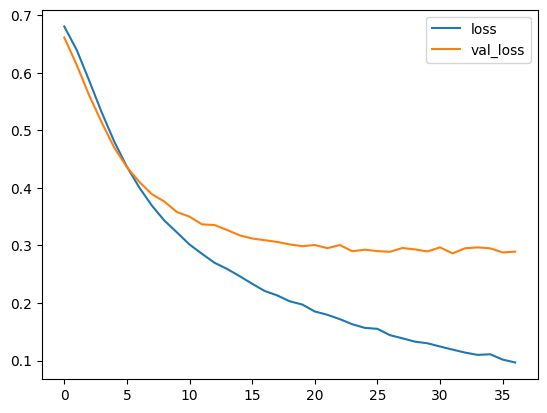

In [14]:
plt.plot(history.history['loss'], label='loss') # Plotando os valores de treino
plt.plot(history.history['val_loss'], label='val_loss') # Plotando os valores de validação
plt.legend() # Exibindo as legendas
plt.show() # Exibindo o gráfico

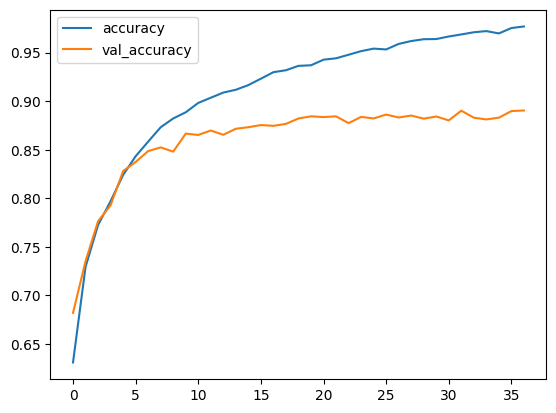

In [15]:
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy') # Plotando os valores de treino
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy') # Plotando os valores de validação
plt.legend() # Exibindo as legendas
plt.show() # Exibindo o gráfico

### Fazendo o predict do modelo com uma amostra dos dados

In [24]:
for i in range (10): # Criando uma estrutura de repetição para avaliar os 10 primeiros reviews
    
    print(f'Review {i}:') # Printando o número do review
    decoded_text = decode_review(x_test[i], word_index) # Usando a função para decodificar e visualizar o primeiro review, passando um review e o dicionário de palavras
    print('\n'.join([decoded_text[i:i+120] for i in range(0, len(decoded_text), 120)])) # Printando o texto com limite de 120 caracteres

    print() # Printando uma linha vazia para separar o texto das previsões

    prediction = np.argmax(model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)) # Armazenando em variável a previsão para otimizar o código ao printar logo abaixo
    probabilities = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0).flatten() # Armazenando em variável as probabilidades para otimizar o código ao printar logo abaixo
    print('- Result:', 'Right' if y_test[i] == prediction else 'Wrong') # Printando o resultado da previsão
    print('- Correct Answer:', 'Negative Review' if y_test[i] == 0 else 'Positive Review') # Printando a resposta correta
    print('- Prediction:', 'Negative Review' if prediction == 0 else 'Positive Review') # Printando a previsão do modelo
    print(f'- Probabilities: Negative Review = {probabilities[0] * 100:.1f}% - Positive Review = {probabilities[1] * 100:.1f}%') # Printando as probabilidades de cada possível resposta
    
    print('\n') # Printando duas linhas vazias para separar os reviews

Review 0:
<START> please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the sho
w is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to 
know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss <PA
D> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA
D> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA
D> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA
D> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA
D> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA
D> <PAD> <PAD> <PAD> <

### Testando o modelo com reviews criados manualmente

In [118]:
positive_review = 'Excellent actors, incredible cast, and flawless performances. A true work of art that deserves to be appreciated on the big screen. A beautiful job by the director and the entire team of writers and producers! However, the cinematography of the film left something to be desired; it could have been better.' # Armazenando em uma variável um review positivo
negative_review = 'I really would not spend my money if I knew this was a terrible movie. A big waste of time and money on the ticket. But in the end, we can highlight some positives, such as the cast is performances and a great ending to the film.' # Armazenando em uma variável um review negativo

In [119]:
def encode_review(text, index): # Criando uma função para transformar os reviews, de um texto normal para uma sequência de números, passando um texto e o dicionário de palavras
    text = text.translate(str.maketrans('', '', string.punctuation)).lower() # Tratando o texto, removendo pontuações e transformando todo o texto em letra minúscula
    return [index.get(word, 2) for word in text.split(' ')] # Retornando o texto transformado em uma sequência de números com base no dicionário de palavras

In [120]:
positive_review = keras.utils.pad_sequences( # Ajustando o novo valor do review para otimizar os recursos de processamento, limitando os reviews em 50 tokens (nesse caso, palavras). Para reviews menores, serão preenchidos com <PAD>. Para reviews maiores, serão cortados em 50 tokens.
    [encode_review(positive_review, word_index)], # Passando os dados que serão alterados
    value=word_index['<PAD>'], # Passando o valor que preenchera os espaços vazios caso os reviews tenham menos de 50 tokens
    padding='post', # Definindo se os reviews com menos de 50 tokens, vão ser preenchidos com <PAD> no início ou no final
    truncating='post', # Definindo se os reviews com mais de 50 tokens, vão ser cortados no início ou no final
    maxlen=50 # Definindo o número máximo de tokens
)

negative_review = keras.utils.pad_sequences( # Ajustando o novo valor do review para otimizar os recursos de processamento, limitando os reviews em 50 tokens (nesse caso, palavras). Para reviews menores, serão preenchidos com <PAD>. Para reviews maiores, serão cortados em 50 tokens.
    [encode_review(negative_review, word_index)], # Passando os dados que serão alterados
    value=word_index['<PAD>'], # Passando o valor que preenchera os espaços vazios caso os reviews tenham menos de 50 tokens
    padding='post', # Definindo se os reviews com menos de 50 tokens, vão ser preenchidos com <PAD> no início ou no final
    truncating='post', # Definindo se os reviews com mais de 50 tokens, vão ser cortados no início ou no final
    maxlen=50 # Definindo o número máximo de tokens
)

In [121]:
x_test_manual = [positive_review, negative_review] # Definindo o x de teste com os reviews manuais
y_test_manual = [1, 0] # Definindo o y de teste com os reviews manuais

In [122]:
for i in range (len(x_test_manual)): # Criando uma estrutura de repetição para avaliar os reviews
    
    print(f'Review {i}:') # Printando o número do review
    decoded_text = decode_review(x_test_manual[i][0], word_index) # Usando a função para decodificar e visualizar o primeiro review, passando um review e o dicionário de palavras
    print('\n'.join([decoded_text[i:i+120] for i in range(0, len(decoded_text), 120)])) # Printando o texto com limite de 120 caracteres

    print() # Printando uma linha vazia para separar o texto das previsões

    prediction = np.argmax(model.predict(np.expand_dims(x_test_manual[i][0], axis=0), verbose=0)) # Armazenando em variável a previsão para otimizar o código ao printar logo abaixo
    probabilities = model.predict(np.expand_dims(x_test_manual[i][0], axis=0), verbose=0).flatten() # Armazenando em variável as probabilidades para otimizar o código ao printar logo abaixo
    print('- Result:', 'Right' if y_test_manual[i] == prediction else 'Wrong') # Printando o resultado da previsão
    print('- Correct Answer:', 'Negative Review' if y_test_manual[i] == 0 else 'Positive Review') # Printando a resposta correta
    print('- Prediction:', 'Negative Review' if prediction == 0 else 'Positive Review') # Printando a previsão do modelo
    print(f'- Probabilities: Negative Review = {probabilities[0] * 100:.1f}% - Positive Review = {probabilities[1] * 100:.1f}%') # Printando as probabilidades de cada possível resposta
    
    print('\n') # Printando duas linhas vazias para separar os reviews

Review 0:
excellent actors incredible cast and flawless performances a true work of art that deserves to be appreciated on the big
 screen a beautiful job by the director and the entire team of writers and producers however the cinematography of the f
ilm left something to be desired it could have been

- Result: Right
- Correct Answer: Positive Review
- Prediction: Positive Review
- Probabilities: Negative Review = 0.1% - Positive Review = 99.8%


Review 1:
i really would not spend my money if i knew this was a terrible movie a big waste of time and money on the ticket but in
 the end we can highlight some positives such as the cast is performances and a great ending to the film <PAD> <PAD> <PA
D>

- Result: Right
- Correct Answer: Negative Review
- Prediction: Negative Review
- Probabilities: Negative Review = 99.7% - Positive Review = 0.3%


